## K-medias con PySpark

En este notebook haremos una revisión de como usar la técnica de K-medias para tareas de agrupamiento (clustering).

Supongamos que tenemos una coleccion de puntos
que viven en un espacio

-dimensional. Dichos puntos no están asociados a ningun tipo de clase o algo parecido. Sin embargo, nosotros podríamos estar interesados en encontrar elementos similares entre si. Los algoritmos de agrupamiento responden a esta necesidad, permitiéndonos crear grupos de objetos, de tal forma que los objetos dentro de un mismo grupo presentan cierto grado de similaridad.

K-medias (K-means en ingles) es una tecnica de agrupamiento, de las muchas que existen. Conceptualmente hablando, un paso difícil de difinir es como medir las similaridad entre objetos. En el caso particular de nuestro conjunto de puntos, la idea de que los puntos similares son los que están cerca entre si aparece de forma natural. K-medias hace uso justo esta idea, definiendo como medida de similaridad la distancia euclidiana
La idea general detrás K-medias es la de encontrar puntos
que sirvan para representar grupos de elementos, de forma especifica son los promedios (por eso la palabra medias) de todos los puntos que encuentran en un mismo grupo. Cada punto puede ser asignado unicamente a un grupo, se le asigna al grupo representado por el

más cercano.

De forma algorítmica, y muy a grosso modo, la técnica de K-medias puede describirse de la siguiente manera

    Inicializar K puntos

de forma aleatoria.
Encontrar el
que es mas cercano a cada
, lo cual asignara automaticamente a cada
un grupo.
Recalcule las medias

    usando los grupos encontrados en el paso 2.
    Regrese al paso 2.

Una descripción más detallada de la técnica de K-medias puede encontrarse en la sección 6.1 del libro A First Course in Machine Learning de Rogers y Girolami

In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
import pyspark
# Carga ufnciones extra
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_medias').getOrCreate()

25/03/01 08:33:06 WARN Utils: Your hostname, vania-Latitude-7400 resolves to a loopback address: 127.0.1.1; using 10.153.221.214 instead (on interface wlo1)
25/03/01 08:33:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 08:33:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Además de PySpark usaremos:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
# Para usar K-medias con pyspark
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.linalg import Vectors
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import * 

### Datos

Para poder graficar los guardamos en un DF de pandas

In [4]:
puntos, grupos_real = make_blobs(n_samples    = 100, 
                                 centers      = 2, 
                                 n_features   = 2, 
                                 random_state = 12) 

pdf_kmedias = pd.DataFrame(puntos, columns=['x','y'])

grafiquemos los datos

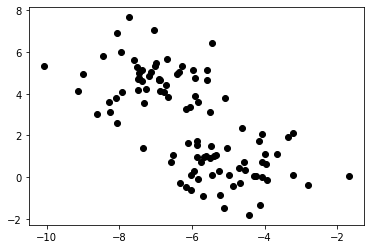

In [5]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = 'black')

### Preparar los datos

Para poder usar los modelos de pyspark.ml debemos reformatear los datos de la siguiente forma

In [6]:
# Da formato para poder usar datos en modelos de pyspark.ml

df_brutos = spark.createDataFrame(pdf_kmedias)

df_kmedias = df_brutos.withColumn('variables', array(df_brutos.columns)) \
                      .rdd.map(lambda renglon: Vectors.dense(renglon.variables))

df_kmedias = spark.createDataFrame(df_kmedias.map(Row), ['variables'])

df_kmedias.show(5, truncate = False)

+----------------------------------------+
|variables                               |
+----------------------------------------+
|[-10.064159673950533,5.3361298235882115]|
|[-5.93934529638521,0.2932430254612975]  |
|[-4.282810462818456,0.03337804988534199]|
|[-3.9682695610300134,0.6462729900646167]|
|[-5.580911813734784,5.119659218324231]  |
+----------------------------------------+
only showing top 5 rows



### Entrenar modelo

A ojo de buen cubero se pueden distinguir dos grupos. Usemos K-medias para encontrar estos grupos. Entrenemos al modelo

In [7]:
# k es el numero de grupos (clusters)
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)

In [8]:
modelo

KMeansModel: uid=KMeans_9d9b700b9ebd, k=2, distanceMeasure=euclidean, numFeatures=2

### Hacer predicciones

In [9]:
grupos_pred = modelo.transform(df_kmedias)

Pasemoslo a un DataFrame de pandas

In [10]:
df_kmedias.head(5)

[Row(variables=DenseVector([-10.0642, 5.3361])),
 Row(variables=DenseVector([-5.9393, 0.2932])),
 Row(variables=DenseVector([-4.2828, 0.0334])),
 Row(variables=DenseVector([-3.9683, 0.6463])),
 Row(variables=DenseVector([-5.5809, 5.1197]))]

In [11]:
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

0    0
1    1
2    1
3    1
4    0
Name: prediction, dtype: int32

Cambiamos a colores para graficar

In [12]:
grupos_colores = []

for g in grupos_pred:
    if g == 1:
        grupos_colores.append('blue')
    else:
        grupos_colores.append('red')

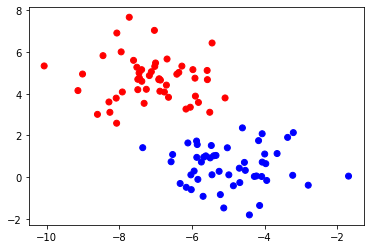

In [13]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = grupos_colores)

### Evaluar modelo

Podemos evaluar el modelo calculando la matriz de confusión

In [14]:
grupos_pred

0     0
1     1
2     1
3     1
4     0
     ..
95    0
96    1
97    1
98    0
99    0
Name: prediction, Length: 100, dtype: int32

In [15]:
grupos_real

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0])

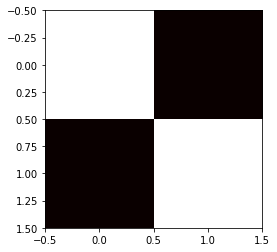

In [16]:
mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

Notemos que probablemente el grupo real 1 hace referencia al grupo 0 predecido, debido a que no asignamos explícitamente etiquetas a los grupos, el comportamiento ideal sera cuando la mayor cantidad de clasificaciones aparezcan en cualquiera de las dos diagonales.

### Otras formas de agrupar

A continuación presentamos más formas de realizar la tarea de agrupamiento en PySpark, las explicaciones de cada una de estas técnicas escapan a los propósitos de este notebook.

#### K-medias con distancia coseno

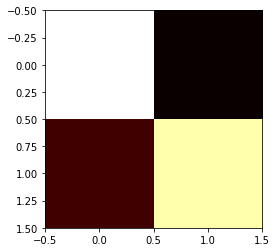

In [17]:
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables', distanceMeasure = 'cosine')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

#### Gaussian mixture models

25/03/01 08:54:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/03/01 08:54:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
25/03/01 08:54:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/03/01 08:54:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/03/01 08:54:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/01 08:54:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


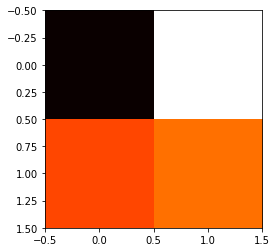

In [18]:
kmedias = GaussianMixture(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

### Bisecting K-medias

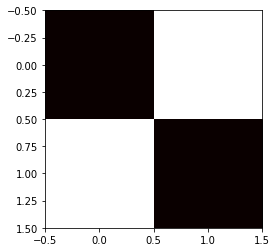

In [19]:
kmedias = BisectingKMeans(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

### Práctica III (Individual)

Cree su propia base de datos cambiando el sus hiperparámetros de la función make_blobs. Grafique (si es posible) sus datos.
Emplee todos las técnicas de agrupamiento y reporte los resultados.

Basado en los apuntes del Dr. Gibran Fuentes